# Mandlebrot set visualisation

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Complex numbers native to Python!

In [5]:
demorgan = 1+1j
print(demorgan, type(demorgan))
print(demorgan.conjugate())

(1+1j) <class 'complex'>
(1-1j)


## Mandlebrot set definition:

The subset of complex numbers $c$ in the complex plane such that the function:
$$
f_{c}(z) = z^2 + c
$$
does not diverge to infinity, when $f$ is iterated, from initial condition $z$.

ie, the sequence $ (f_c(0), \ f_c(f_c(0)), \ f_c^3(0), \ ... )$ remains bounded in absolute value.

In [92]:
def mandlebrot_f(c: complex, z: complex) -> complex:
    '''
    Mandlebrot generator function f_c(z)=z^2 + c
    '''
    return z*z + c

First step is to visualise a single sequence f, f(f), f(f(f)),..., iterating N times and plotting

In [93]:
def recursion_list(c: complex, N: int, recursion_func = mandlebrot_f)->list[complex]:
    '''
    Packaging function to recursively call recursion_func N times.
    recursion_func must accept z and c as arguments.
    Returns a list of complex z values 
    '''
    if N <= 0:
        raise ValueError("Please supply a number of iterations over 0.")
    try:
        _ = recursion_func(c=0+0j, z=0+0j)
    except:
        raise Exception("Please change recursion_func so that it accepts c and z as arguments.")

    z: complex = 0+0j
    results = [z]

    # Call recursion func N times on z=0+0i input
    for iter_num in range(N):
        z = recursion_func(c=c,z=z)
        results += [z]
    
    return results

def unpacker(results: list[complex]) -> (np.ndarray, np.ndarray):
    N = len(results)
    x_vals, y_vals = np.zeros(N), np.zeros(N)
    for iter_num in range(N):
        val = results[iter_num]
        x_vals[iter_num], y_vals[iter_num] = val.real, val.imag
    return (x_vals, y_vals)

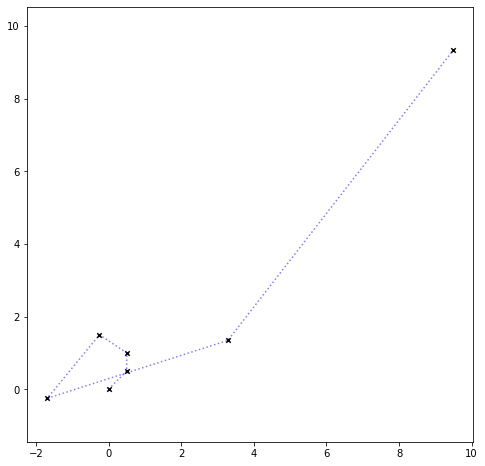

In [94]:
c: complex = 0.5 + 0.5j

x_vals, y_vals = unpacker(recursion_list(c=c,N=6))
fig = plt.figure(figsize=[8,8])

plt.plot(x_vals, y_vals, alpha=0.5, c='b',linestyle=':')
plt.scatter(x_vals, y_vals, marker='x', c='k', s=20)
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.axis('equal')
plt.show()

# General plot

Now we make a more general function to find if a point $c \in \mathbb{C}$ diverges under our function

In [162]:
def recursion(c: complex, N: int, recursion_func = mandlebrot_f) -> complex:
    '''
    Packaging function to recursively call recursion_func N times.
    recursion_func must accept z and c as arguments.
    Returns the final z value
    '''
    if N <= 0:
        raise ValueError("Please supply a number of iterations over 0.")
    
    # Bugfixing, would slow code down
    #try:
    #    _ = recursion_func(c=0+0j, z=0+0j)
    #except:
    #    raise Exception("Please change recursion_func so that it accepts c and z as arguments.")

    z: complex = 0+0j

    # Call recursion func N times on z=0+0i input
    for iter_num in range(N):
        z = recursion_func(c=c,z=z)

    return z

def get_colour(c: complex, N: int = 10, recursion_func = mandlebrot_f) -> float:
    '''
    Function taking point c in complex plane, and calling it's recursive function f_c N times.
    Determines colour based on absolute value of final point.
    '''
    # Check c isn't outside r=2 disc - we know these diverge
    abs_c = abs(c)
    if abs_c >= 2:
        return 0

    # Call recursive function N times
    final_z = recursion(c,N,recursion_func)

    # Find its absolute value
    try:
        abs_z = abs(final_z)
    except:
        return 0
    
    if np.isnan(abs_z):
        return 0
    
    # Return piecewise colour function of absolute value
    cut_off = 2
    if abs_z <= cut_off:
        return 1
    else:
        scale = 1
        return np.exp(-scale*(abs_z-cut_off))

def pixel_to_complex_coords(u: int,v: int, res_x:int=500, res_y:int=500) -> complex:
    '''
    Function to convert pixel coordinates in a certain resolution pixel frame into complex coords.
    res_x and res_y must be even
    '''
    if res_x % 2 == 1 or res_y % 2 ==1 or res_x <= 2 or res_y <= 2:
        raise ValueError("Please input positive, even resolutions for x and y.")
    # Calculate width w of a pixel in complex coord frame
    # Our image should at minimum view [2,2]^2 
    frame_bounds = 2
    w = frame_bounds * (2/(min(res_x,res_y)))
    
    # Calculate top left x and y complex points
    top_left_x, top_left_y = -w*(res_x/2)+w/2 , w*(res_y/2)-w/2

    # Calculate complex points
    x,y = top_left_x + u*w, top_left_y - v*w

    return complex(x,y)


# Main rendering function
def get_image_vals(res_x:int=500, res_y:int=500, N: int = 10, recursion_func = mandlebrot_f) -> np.ndarray:
    '''
    Gets a matrix of res_x by res_y values, and queries the colour for each with get_colour.
    '''
    image_matrix = np.zeros([res_x, res_y])

    for u in range(res_x):
        for v in range(res_y):
            c = pixel_to_complex_coords(u=u, v=v, res_x=res_x, res_y=res_y)
            image_matrix[u,v] = get_colour(c=c, N=N, recursion_func=recursion_func)

    return image_matrix

In [163]:
# Calculate values
res_x, res_y = 200,100
image_matrix = get_image_vals(res_x=res_x, res_y=res_y, N=15)

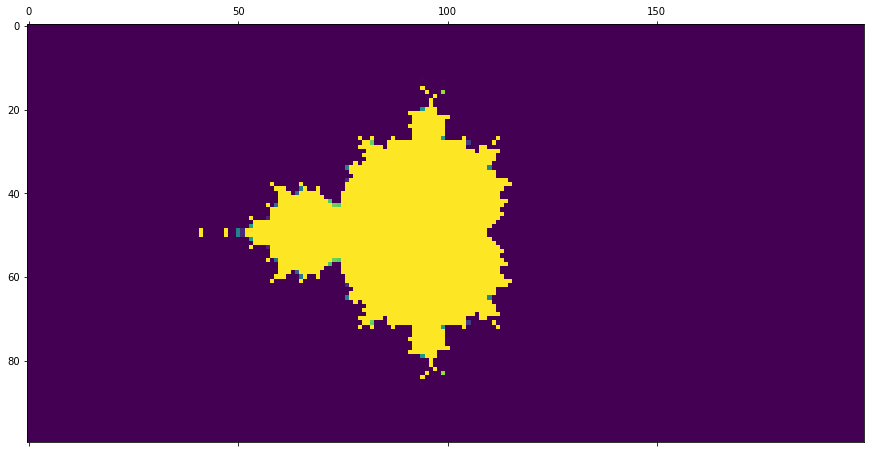

In [155]:
# Plot values 
fig = plt.figure(figsize=[15,15])
plt.matshow(image_matrix.transpose(), fignum=0, vmin=0, vmax=1) # Note because of matshow we need to transpose the matrix
plt.show()

## Zooming in

In [203]:
def get_colour(c: complex, N: int = 10, recursion_func = mandlebrot_f) -> float:
    '''
    Function taking point c in complex plane, and calling it's recursive function f_c N times.
    Determines colour based on absolute value of final point.
    '''
    # Check c isn't outside r=2 disc - we know these diverge
    abs_c = abs(c)
    if abs_c >= 2:
        return 0

    # Call recursive function N times
    final_z = recursion(c,N,recursion_func)

    # Find its absolute value
    try:
        abs_z = abs(final_z)
    except:
        return 0
    if np.isnan(abs_z):
        return 0
    
    # Return piecewise colour function of absolute value
    cut_off = 2
    if abs_z <= cut_off:
        return 1
    else:
        scale = 0.01
        return np.exp(-scale*(abs_z-cut_off))

def step_pixel_to_complex_coords(u: int,v: int, res_x:int=500, res_y:int=500,
                                  focus: complex = 0+0j,
                                  step: int = 0) -> complex:
    '''
    Function to convert pixel coordinates in a certain resolution pixel frame into complex coords.
    res_x and res_y must be even
    '''
    # Calculate width w of a pixel in complex coord frame
    # Our image should at minimum view [2,2]^2 
    w = 2 * (2/(min(res_x,res_y))) * 2/(2*(step+1))
    
    # Calculate top left x and y complex points
    top_left_x, top_left_y = focus.real + -w*(res_x/2)+w/2 , focus.imag + w*(res_y/2)-w/2

    # Calculate complex points
    x,y = top_left_x + u*w, top_left_y - v*w

    return complex(x,y)

def step_get_image_vals(step: int = 0, res_x:int=500, res_y:int=500, focus: complex = 0+0j,
                        N: int = 10, recursion_func = mandlebrot_f) -> np.ndarray:
    '''
    Gets a matrix of res_x by res_y values for a particular step, and queries the colour for each with get_colour.
    '''
    image_matrix = np.zeros([res_x, res_y])

    for u in range(res_x):
        for v in range(res_y):
            c = step_pixel_to_complex_coords(u=u, v=v, res_x=res_x, res_y=res_y, 
                                             focus=focus,step=step)
            image_matrix[u,v] = get_colour(c=c, N=N, recursion_func=recursion_func)

    return image_matrix

def zoom_in_step(step: int, ax, focus: complex,
            res_x: int, res_y: int, num_frames: int, recentering_steps: int = 5, N: int = 10):
    ''' 
    Zoom in function, renders the Nth step
    Phase 1: Recentering
        Move from origin to supplied focus point in recentering_steps many steps, while zooming in
    Phase 2: Normal zooming
        Just zoom in for the remaining steps
    '''
    if res_x % 2 == 1 or res_y % 2 ==1 or res_x <= 2 or res_y <= 2:
        raise ValueError("Please input positive, even resolutions for x and y.")
    if step < 0:
        raise ValueError("Can't have negative step")
    
    print(f"Step {round(step+1)}/{num_frames}", end='\r', flush=True)

    if step <= recentering_steps: # Phase 1
        current_focus = focus * step/recentering_steps
        image_matrix = step_get_image_vals(res_x=res_x, res_y=res_y, N=N,
                                            focus=current_focus, step=step)
    else: # Phase 2
        image_matrix = step_get_image_vals(res_x=res_x, res_y=res_y, N=N,
                                            focus=focus, step=step)
    
    ax = ax[0]
    ax.clear()
    ax.set_axis_off()
    cmap = plt.cm.afmhot_r
    ax.matshow(image_matrix.transpose(), vmin=0, vmax=1, cmap=cmap)
    

Runtime approximately 40 seconds
-
Step 20/20

Saved simulation as mp4 at Mandlebrot_400_by_400_with_20_steps.mp4.


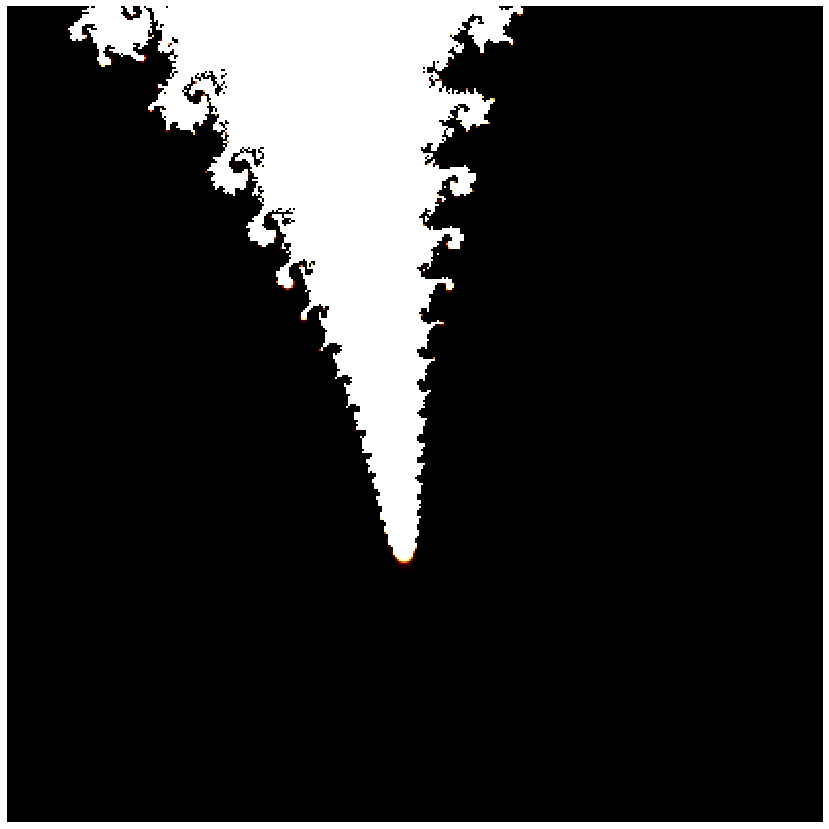

In [204]:
interval_between_frames = 200 # milliseconds
num_frames = 20
focus = -0.75+0.1j
res_x, res_y = 400,400
N = 50

print(f"Runtime approximately {round(num_frames*(res_x*res_y)/80000)} seconds")
print("-")

fig, ax = plt.subplots(figsize=[15,15])
scat = ax.scatter([], [])

ani = FuncAnimation(fig, zoom_in_step, frames=num_frames, \
                        fargs=([ax],focus,res_x,res_y,num_frames, 5, N,), interval=interval_between_frames)

save_as_mp4 = True
if save_as_mp4:
    mp4_path = f"Mandlebrot_{res_x}_by_{res_y}_with_{num_frames}_steps.mp4"
    fps = 1/(interval_between_frames*(10**(-3))) # period -> frequency
    ani.save(mp4_path, writer='ffmpeg', fps=fps)
    print("\n")
    print(f"Saved simulation as mp4 at {mp4_path}.")

plt.show()

In [207]:
def render_zoom_in(focus: complex,
                    res_x: int = 400, res_y: int = 400, N: int = 50,
                    num_frames: int = 20, interval_between_frames: int = 200,
                    centering_frames: int = 5,
                    save_as_mp4: bool = True, user_mp4_path: str = None):
    ''' 
    Render mandelbrot zoom.

    focus - complex number that we zoom in on
    res_x, res_y - even integers for x and y resolution, default 400,400
    num_frames - number of frames, each frame zooms in
    interval_between_frames - interval in milliseconds between frames
    centering_frames - number of initial frames used to center on our focus
    save_as_mp4 - bool, whether to save as mp4
    user_mp4_path - path to save the mp4
    '''

    print(f"Runtime approximately {round(num_frames*(res_x*res_y)/80000)} seconds")
    print("-")

    fig, ax = plt.subplots(figsize=[15,15])
    _ = ax.scatter([], [])

    ani = FuncAnimation(fig, zoom_in_step, frames=num_frames, \
                            fargs=([ax],focus,res_x,res_y,num_frames, centering_frames, N,),
                              interval=interval_between_frames)

    save_as_mp4 = True
    if save_as_mp4:
        mp4_path = f"renders/Mandlebrot_{res_x}_by_{res_y}_with_{num_frames}_steps.mp4"
        if user_mp4_path:
            mp4_path = "renders/" + user_mp4_path
            if not mp4_path.lower().endswith('.mp4'):
                file_path += '.mp4'
        fps = 1/(interval_between_frames*(10**(-3))) # period -> frequency
        ani.save(mp4_path, writer='ffmpeg', fps=fps)
        print("\n")
        print(f"Saved simulation as mp4 at {mp4_path}.")
    plt.show()

Runtime approximately 40 seconds
-
Step 20/20

Saved simulation as mp4 at renders/Seahorse.mp4.


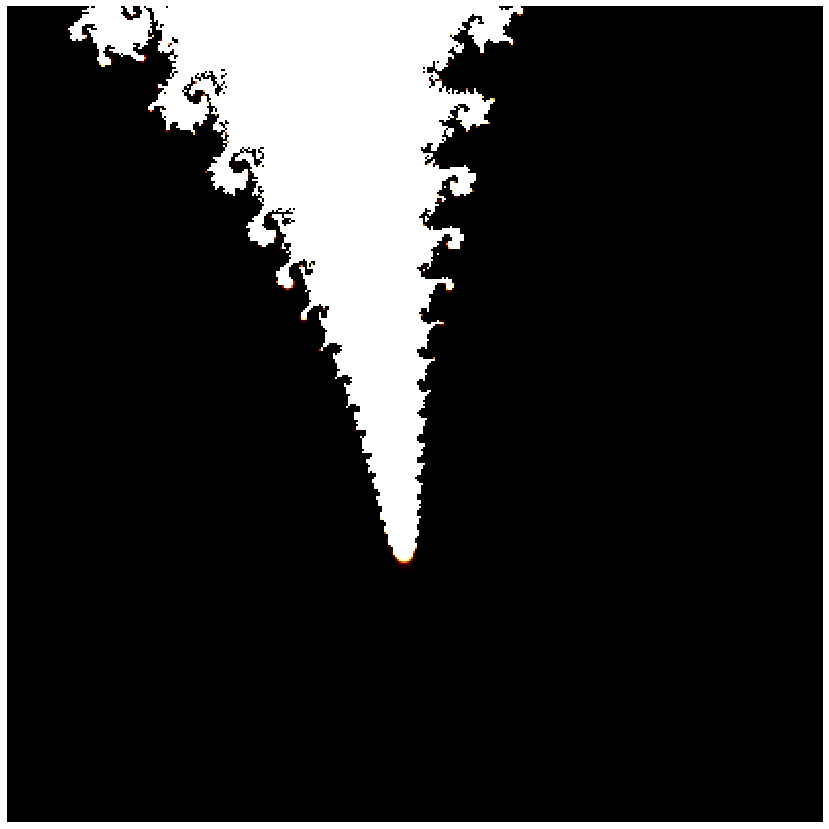

In [208]:
seahorse = -0.75+0.1j
elephant = 0.28 + 0.01j
minibrot = -1.25 + 0j
spiral = -0.1011 + 0.9563j
antenna =  -0.1566 + 1.0323j
cross = -0.743643135 + 0.131825963j

render_zoom_in(focus=seahorse, user_mp4_path="Seahorse.mp4")